In [1]:
!pip install -qU category_encoders optuna

     |████████████████████████████████| 86 kB 2.6 MB/s 
     |████████████████████████████████| 308 kB 36.1 MB/s 
     |████████████████████████████████| 81 kB 6.5 MB/s 
     |████████████████████████████████| 210 kB 37.7 MB/s 
     |████████████████████████████████| 78 kB 5.6 MB/s 
     |████████████████████████████████| 150 kB 45.3 MB/s 
     |████████████████████████████████| 113 kB 49.1 MB/s 
     |████████████████████████████████| 49 kB 4.9 MB/s 


In [2]:
import warnings
warnings.filterwarnings('ignore')

import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tqdm.notebook import tqdm
from sklearn.metrics import f1_score, roc_auc_score, classification_report, accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV

from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

from itertools import combinations
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline

import category_encoders as ce

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer

from scipy import stats

import optuna
from optuna.samplers import TPESampler

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
np.random.seed(1)
train_root = '/content/drive/My Drive/data/titanic_set/train.csv'
test_root = '/content/drive/My Drive/data/titanic_set/test.csv'

In [5]:
train_df = pd.read_csv(train_root, index_col='PassengerId')
test_df = pd.read_csv(test_root, index_col='PassengerId')
TARGET_NAME = 'Survived'

In [ ]:
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
def effect_size(factor_a, factor_b, cohen=True, desired_power=0.8, alpha=0.05):
    n1, n2 = len(factor_a), len(factor_b)
    s1, s2 = factor_a.std(ddof=1), factor_b.std(ddof=1)
    df = (s1 ** 2 / n1 + s2 ** 2 / n2) ** 2 / \
          ((s1 ** 2 / n1) ** 2 / (n1 - 1) + (s2 ** 2 / n2) ** 2 / (n2 - 1))
    if cohen:
        sigma_pooled = np.sqrt(((n1 - 1) * s1**2 + (n2 - 1) * s2**2) / (n1 + n2 - 2))
        return np.abs(factor_a.mean() - factor_b.mean()) / sigma_pooled, df
    else:
        return power.tt_ind_solve_power(effect_size=None, nobs1=len(factor_a), alpha=alpha, power=desired_power,
                                        ratio=len(factor_b)/len(factor_a), alternative='two-sided'), df

def statistic_output(*columns, df=train_df, cat=False, target=TARGET_NAME, alpha=0.05, sample_size=0):
    data = df.copy()
    data.drop_duplicates(inplace=True)
    if sample_size == 0:
        sample_size = int(0.05 * len(data))
    if not cat:
        columns = data.drop(target, axis=1).select_dtypes(exclude=['category', np.object]).columns
        for column in columns:
            df_sampled = data[[column, target]].sample(sample_size, random_state=1)
            factor_a = df_sampled.loc[df_sampled[target] == 0][column]   
            factor_b = df_sampled.loc[df_sampled[target] == 1][column]
            var_a, var_b = factor_a.var(), factor_b.var()   
            _, pvalue = stats.shapiro(df_sampled[column])
            if pvalue >= alpha:
                _, pvalue = stats.ttest_ind(factor_a, factor_b, equal_var=False)
                test = power.TTestIndPower()
                eff_size, deg_free = effect_size(factor_a, factor_b, cohen=False)
                pow = test.power(effect_size=eff_size, nobs1=len(factor_a), alpha=alpha, df=deg_free, 
                                 ratio=len(factor_b)/len(factor_a), alternative='two-sided')
            else:
                _, pvalue = stats.mannwhitneyu(factor_a, factor_b)
                pow, eff_size = None, None
            if pvalue < alpha:
                result = f'with effect_size = {eff_size:.4f} and ttest power {pow*100:.2f}%' if pow is not None else ''
                print(f'Factor "{column}" has statistical influence on target (var_a: {var_a:.2f}, var_b: {var_b:.2f}). {result}')
            else:
                print(f'Factor "{column}" does not affect target.')
    else:
        for column in columns:
            print(column)
            data.reset_index(inplace=True)
            categories = data[column].unique().tolist()
            for pair in combinations(categories, r=2):
                a, b = pair
                if a != b:
                    data_ = data.loc[data[column].isin(pair), ['PassengerId', column, target]].sample(sample_size, random_state=1)
                    table = data_.pivot_table(values='PassengerId', index=column, columns=target, aggfunc='count')
                    _, pvalue, _, _ = stats.chi2_contingency(table, correction=False)
                    if pvalue >= alpha:  
                        print(f'Categories {a} and {b} can be united.')
                    else:
                        print(f'Categories {a} and {b} have different frequencies with target.')

def correlation(df: pd.DataFrame, target=TARGET_NAME, alpha=0.05, threshold=0.66, method='pearson'):
    data = df.copy()
    data = data.drop(target, axis=1)
    columns = data.select_dtypes(exclude=['category', np.object]).columns
    for pair in combinations(columns, r=2):
        col1, col2 = pair
        if method == 'pearson':
            r, pvalue = stats.pearsonr(data[col1], data[col2])
        elif method == 'kendall':
            r, pvalue = stats.kendalltau(data[col1], data[col2])
        elif method == 'spearman':
            r, pvalue = stats.spearmanr(data[col1], data[col2])                   
        else:
            raise ValueError(f'Method should be "spearman", "kendall" or "pearson", got: {method}')
        if r >= threshold:    
            if pvalue < alpha:
                print(f'Correlation ({method}) between {col1} and {col2} is statisticaly strong: {r:.4f}.')
            else:
                print(f'Correlation ({method}) between {col1} and {col2} is high but not statisticaly meaningful.')

In [ ]:
train_df['Embarked'].fillna(train_df['Embarked'].mode()[0], inplace=True)
statistic_output('Sex', 'Pclass', 'Embarked', cat=True, sample_size=100)

Sex
Categories male and female have different frequencies with target.
Pclass
Categories 3 and 1 have different frequencies with target.
Categories 3 and 2 have different frequencies with target.
Categories 1 and 2 have different frequencies with target.
Embarked
Categories S and C can be united.
Categories S and Q can be united.
Categories C and Q can be united.


In [ ]:
train_df[TARGET_NAME].value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

In [ ]:
train_df.describe(include=np.object)

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,891
unique,891,2,681,147,3
top,"Cairns, Mr. Alexander",male,CA. 2343,C23 C25 C27,S
freq,1,577,7,4,646


In [7]:
X, y = train_df.drop(TARGET_NAME, axis=1), train_df[TARGET_NAME]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=1)

In [10]:
class Preprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, target=TARGET_NAME):
        self.columns = columns
        self.upper_bound = None
        self.temp = None
        self.target = target

    def fit(self, X, y=None):
        # mark ouliers
        q1, q3 = np.quantile(X['Fare'], 0.25), np.quantile(X['Fare'], 0.75)
        self.upper_bound = q3 + 1.5 * (q3 - q1)

        # get aggregation
        if y is not None:
            X_ = pd.concat([X, y], axis=1)
            self.temp = X_.groupby(['Sex', 'Pclass']).agg({self.target: 'count'}).reset_index()
            self.temp = self.temp.rename(columns={self.target: 'tar_count'})

        return self

    def transform(self, X_):
        X = X_.copy()
        # mark outliers
        X['Mark'] = 0
        X.loc[X['Fare'] > self.upper_bound, 'Mark'] = 1
        
        # drop non-informative and na columns
        X.drop(['Ticket', 'Cabin'], axis=1, inplace=True)

        # unite freq equal categories
        X.loc[X['Embarked'] == 'Q', 'Embarked'] = 'S'

        # Add target count feature
        if self.temp is not None:
            X = X.merge(self.temp, on=['Sex', 'Pclass'], how='left')

        # add status
        X['Status'] = X['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
        X['Status'] = X['Status'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 
                                                 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona', 'Master'], 'Single')
        X['Status'] = X['Status'].replace('Mlle', 'Miss')
        X['Status'] = X['Status'].replace('Ms', 'Miss')
        X['Status'] = X['Status'].replace('Mme', 'Mrs')
        X.drop('Name', axis=1, inplace=True)

        # add family
        X['Family'] = X['SibSp'] + X['Parch']

        X['Pclass'] = X['Pclass'].astype(np.object)

        return X

class DataFrameR(BaseEstimator, TransformerMixin):
    def __init__(self, columns, index=None):
        self.columns = columns
        self.index = index

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert len(self.columns) == X.shape[1], f'Number of columns {len(self.columns)} is not equal to data shape {X.shape[1]}'
        if self.index is not None:
            X_ = pd.DataFrame(X, columns=self.columns, index=self.index)
        else:
            X_ = pd.DataFrame(X, columns=self.columns)
        return X_

class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            return X
        return X[self.columns]

class BestSet(BaseEstimator, TransformerMixin):
    def __init__(self, k_features=12, scoring=f1_score, test_size=0.2):
        self.scoring = scoring
        self.k_features = k_features
        self.test_size = test_size

    def fit(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X,
                                                            y, 
                                                            test_size=self.test_size, 
                                                            stratify=y,
                                                            random_state=1)
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores, subsets = [], []
            for p in combinations(self.indices_, r=dim-1):
                score = self._calc_score(X_train, y_train, X_test, y_test, p)
                scores.append(score)
                subsets.append(p)
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]
        return self

    def transform(self, X):
        best_indices = self.subsets_[np.argmax(self.scores_)]
        return X[:, best_indices]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        model = LGBMClassifier(boosting_type='goss',
                               is_unbalance=True,
                               max_depth=3,
                               random_state=1)
        model.fit(X_train[:, indices], y_train)
        y_pred = model.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

In [11]:
one_hot_cols = ['Pclass', 'Status']
bin_cols = ['Sex', 'Embarked']
numerical_cols = ['Age', 'SibSp', 'Parch', 'Fare', 'tar_count', 'Family', 'Mark']

one_hot = Pipeline(steps=[('selector_1', ColumnSelector(one_hot_cols)),
                          ('imputer_1', SimpleImputer(strategy='most_frequent')),
                          ('one_hot', ce.OneHotEncoder(return_df=True))
])

bin_enc = Pipeline(steps=[('selector_2', ColumnSelector(bin_cols)),
                          ('imputer_2', SimpleImputer(strategy='most_frequent')),
                          ('bin_enc', ce.MEstimateEncoder(m=2, return_df=True))
])

numerical_transformer = Pipeline(steps=[('selector_3', ColumnSelector(numerical_cols)),
                                       ('imputer_3', IterativeImputer(random_state=1)),
                                       ('scaler', MinMaxScaler()),
                                       ('to_df', DataFrameR(numerical_cols)),
])

union = FeatureUnion(transformer_list=[('u1', one_hot),
                                       ('u2', bin_enc),
                                       ('u3', numerical_transformer)])

""" not using
col_transformer = ColumnTransformer(transformers=[
                                                  ('bin', bin_enc, bin_cols),
                                                  ('hot', one_hot, one_hot_cols),
                                                  ('num', numerical_transformer, numerical_cols)
], remainder='passthrough')
"""
""" cannot transform validation data with given transformers
fit_params = {'lgbm__early_stopping_rounds': 15,  
              'lgbm__eval_set': [(X_test, y_test)],  
              'lgbm__eval_metric': 'f1',
              'lgbm__verbose': False
}
"""
model_params = {
                'boosting_type':'goss',
                'max_depth': 4,
                'learning_rate':0.1,
                #'reg_alpha': 3.5,
                'reg_lambda': 10.55,
                'objective': 'binary',
                'n_estimators': 800,
                'n_jobs': -1,
                'subsample': 0.6,
                'colsample_bytree': 0.8,
                'num_leaves': 31,
                'is_unbalanced': True,
                #'max_bin': 165,
                #'min_child_samples': 253,
                #'min_child_weight': 0.1, 
                #'min_split_gain': 0.18,
                #'pos_bagging_fraction': 0.5,
                'random_state': 1
}

prep_pipe = Pipeline(steps=[
                            ('preprocessor', Preprocessor()),
                            ('col_trans', union),
                            ('best_cols', BestSet()),
                            ('sampler', SMOTEENN(sampling_strategy=1., random_state=1)),
                            #('lgbm', LGBMClassifier(**model_params))
                            ('forest', RandomForestClassifier(n_estimators=100, 
                                                              max_depth=4,
                                                              max_features='sqrt',
                                                              class_weight='balanced_subsample',
                                                              random_state=1))
])

In [14]:
def objective(trial):
    """
    param_boost = {
                'boosting_type': trial.suggest_categorical('boosting_type', ['goss', 'gbdt']),
                'max_depth': trial.suggest_int('max_depth', 3, 7),
                'learning_rate': trial.suggest_float('learning_rate', 0.03, 0.5),
                'reg_alpha': trial.suggest_float('reg_alpha', 1., 10.8),
                'reg_lambda': trial.suggest_float('reg_lambda', 1., 10.8),
                'objective': 'binary',
                'n_estimators': trial.suggest_int('n_estimators', 50, 200),
                'n_jobs': -1,
                'subsample': trial.suggest_float('subsample', 0.3, 1.),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.),
                'num_leaves': trial.suggest_int('num_leaves', 5, 45),
                'is_unbalanced': True,
                'max_bin': trial.suggest_int('max_bin', 50, 255),
                'min_child_samples': trial.suggest_int('min_child_samples', 165, 255),
                'min_child_weight': trial.suggest_float('min_child_weight', 0.1, 0.5), 
                'min_split_gain': trial.suggest_float('min_split_gain', 0.05, 0.25),
                'pos_bagging_fraction': trial.suggest_float('pos_bagging_fraction', 0.5, 0.7),
                'random_state': 1
    }
    """
    param_forest = {
                    'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
                    'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
                    'max_depth': trial.suggest_int('max_depth', 3, 9),
                    'min_samples_split': trial.suggest_int('min_samples_split', 2, 15),
                    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 15),
                    'min_weight_fraction_leaf': trial.suggest_float('min_weight_fraction_leaf', 0., .5),
                    'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
                    'min_impurity_decrease': trial.suggest_float('min_impurity_decrease', 0., 2.),
                    'bootstrap': trial.suggest_int('bootstrap', 0, 1),
                    'n_jobs': -1,
                    'random_state': 1,
                    'warm_start': trial.suggest_int('warm_start', 0, 1),
                    'class_weight': trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample']),
                    'ccp_alpha': trial.suggest_float('ccp_alpha', 0., 3.),
                    'max_samples': trial.suggest_float('max_samples', 0., 1.)
    }
    if not param_forest['bootstrap']:
        param_forest['max_samples'] = None
    prep_pipe = Pipeline(steps=[
                            ('preprocessor', Preprocessor()),
                            ('col_trans', union),
                            ('best_cols', BestSet()),
                            ('sampler', SMOTEENN(sampling_strategy=1., random_state=1)),
                            #('lgbm', LGBMClassifier(**param_boost))
                            ('forest', RandomForestClassifier(**param_forest))
    ])
    prep_pipe.fit(X_train, y_train)
    
    y_score = prep_pipe.predict_proba(X_test)[:, 1]
    score = roc_auc_score(y_test, y_score)
    
    #y_pred = prep_pipe.predict(X_test)
    #score = accuracy_score(y_test, y_pred)
    
    return score

In [ ]:
study = optuna.create_study(sampler=TPESampler(), direction='maximize')
study.optimize(objective, n_trials=1000, timeout=3600)
print(f'Number of completed trials: {len(study.trials)}')
print('Best trial')
trial = study.best_trial
print(f'Best score: {trial.value}')
print('Best params')
for key, value in trial.params.items():
    print(f'{key}: {value}')

In [ ]:
"""
n_estimators: 459
criterion: entropy
max_depth: 8
min_samples_split: 8
min_samples_leaf: 2
min_weight_fraction_leaf: 0.2782414067690383
max_features: sqrt
min_impurity_decrease: 0.1421249076762276
bootstrap: 1
warm_start: 1
class_weight: balanced
ccp_alpha: 0.2879036467270316
max_samples: 0.3445511272954236
"""

In [21]:
optuna.visualization.plot_param_importances(study)

In [19]:
prep_pipe = Pipeline(steps=[
                            ('preprocessor', Preprocessor()),
                            ('col_trans', union),
                            ('best_cols', BestSet()),
                            ('sampler', SMOTEENN(sampling_strategy=1., random_state=1)),
                            #('lgbm', LGBMClassifier(**trial.params,
                            #                        is_unbalanced=True,
                            #                       random_state=1))
                            ('forest', RandomForestClassifier(**trial.params))
])

In [20]:
prep_pipe[-1].bootstrap = True

prep_pipe.fit(X_train, y_train)
train_preds = prep_pipe.predict(X_train)
test_preds = prep_pipe.predict(X_test)
train_probas = prep_pipe.predict_proba(X_train)[:,1]
test_probas = prep_pipe.predict_proba(X_test)[:,1]
print('Train', classification_report(y_train, train_preds, digits=3), sep='\n')
print('Test', classification_report(y_test, test_preds, digits=3), sep='\n')
print(f'Train roc_auc: {roc_auc_score(y_train, train_probas):.4f}')
print(f'Test roc_auc: {roc_auc_score(y_test, test_probas):.4f}')

Train
              precision    recall  f1-score   support

           0      0.806     0.852     0.828       439
           1      0.738     0.670     0.702       273

    accuracy                          0.782       712
   macro avg      0.772     0.761     0.765       712
weighted avg      0.780     0.782     0.780       712

Test
              precision    recall  f1-score   support

           0      0.832     0.855     0.843       110
           1      0.758     0.725     0.741        69

    accuracy                          0.804       179
   macro avg      0.795     0.790     0.792       179
weighted avg      0.803     0.804     0.804       179

Train roc_auc: 0.8448
Test roc_auc: 0.8642


In [22]:
def cross_validation(clf, X, y, scoring='roc_auc'):
    scores = cross_val_score(estimator=clf, X=X, y=y, cv=10, n_jobs=-1, scoring=scoring)
    print(f'Меры правильности перекрекстной оценки: {scores}')
    print(f'Точность перекретсной оценки: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')        

In [23]:
cross_validation(prep_pipe, X_train, y_train, scoring='roc_auc')

Меры правильности перекрекстной оценки: [0.84253247 0.90340909 0.80232558 0.8989899  0.78829966 0.87752525
 0.80723906 0.93055556 0.85563973 0.75589226]
Точность перекретсной оценки: 0.846 +/- 0.054


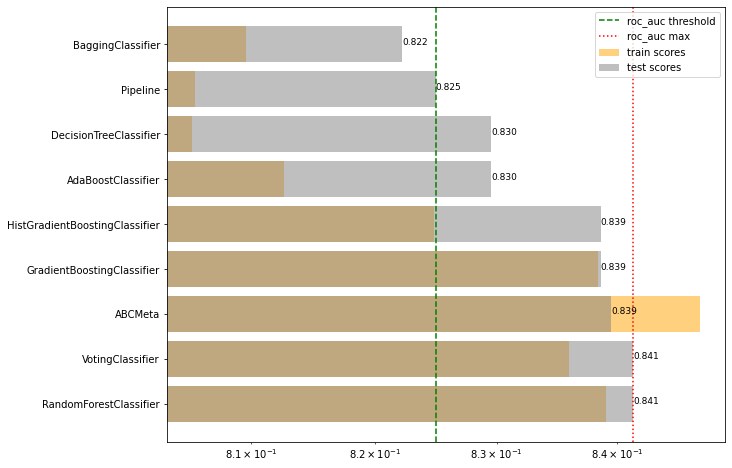

In [ ]:
plt.figure(figsize=(10, 8))
plt.barh(df_res.index, df_res['Train'], alpha=0.5, color='orange', label='train scores')
plt.barh(df_res.index, df_res['Test'], alpha=0.5, color='gray', label='test scores')
plt.axvline(0.825, color='green', linestyle='--', label='roc_auc threshold')
plt.axvline(df_res['Test'].max(), color='red', linestyle=':', label='roc_auc max')
for index, value in enumerate(df_res['Test']):
    plt.text(value, index, f'{value:.3f}', fontsize=9)
plt.legend(loc='best')
plt.xscale('log')
plt.show()

In [ ]:
sub_preds = prep_pipe.predict(test_df)

In [ ]:
sub = pd.DataFrame(np.stack((test_df.index.values, sub_preds), axis=1), columns=['PassengerId', TARGET_NAME])

In [ ]:
sub.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [ ]:
sub.to_csv('submission.csv', index=False, encoding='utf-8')

In [ ]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions submit -c titanic -f submission.csv -m 'test1'

Saving kaggle.json to kaggle.json
kaggle.json
100% 2.77k/2.77k [00:00<00:00, 13.1kB/s]
Successfully submitted to Titanic - Machine Learning from Disaster